# A model that can recognise my roomate's dog and some other objects

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os,shutil
from PIL import Image
from tensorflow.keras import layers as Layers

print(tf.__version__)

2.0.0-dev20190629


In [52]:
## one of (96, 96), (128, 128), (160, 160),(192, 192), or (224, 224)
img_size = 96

## Prepare data

In [3]:
"""
Copy a portion of the Caltech 101 petimages to use as data for this model
Also include some of the images of Bela

This creates folders and fills them with the data,
needs to run everytime in the start as I'm lazy to fix it, 
so you need to delete the folders if you start from a new kernel
to prevent duplicating examples
"""

main_dir = "/home/rimogardino/Programs/ML/Data/cats vs dogs/PetImages/Caltech 101 for bella"
target_dir = "/home/rimogardino/Programs/ML/Data/cats vs dogs/PetImages/Bella"

train_dir = os.path.join(target_dir, "train")
validate_dir = os.path.join(target_dir, "validate")
test_dir = os.path.join(target_dir, "test")

data_split = {"train": [0,40], "validate": [40,50], "test": [50,60]}



for sub_dir in os.listdir(main_dir):
    for data_key, data_range in data_split.items():
        stat_dir = os.path.join(target_dir, data_key)
        curr_stat_dir = os.path.join(stat_dir, sub_dir)
        try:
            os.mkdir(stat_dir)
        except:
            pass
        try:
            os.mkdir(curr_stat_dir)
        except:
            pass
        file_list = os.listdir(os.path.join(main_dir, sub_dir))
        np.random.shuffle(file_list)
        for fname in file_list[data_range[0]:data_range[1]]:
            src = os.path.join(main_dir, sub_dir + "/" + fname)
            target = os.path.join(curr_stat_dir, fname)
            shutil.copy(src, target)   

## Create Data generators.

In [53]:
## the batch size should ideally be bigger, at least 10 I think, but my GPU can't handle it with the pruning
## It only has 2gb of memory..
batch_size = 5
test_batch_size = 5
######
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255,
                                                                rotation_range=40,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True,
                                                                fill_mode='nearest')

val_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)


############
train_gen = train_data_gen.flow_from_directory(train_dir,
                                              target_size=(img_size, img_size),
                                              class_mode="categorical",
                                              batch_size=batch_size,)

val_gen = val_data_gen.flow_from_directory(validate_dir,
                                              target_size=(img_size, img_size),
                                              class_mode="categorical",
                                              batch_size=batch_size,)

test_gen = val_data_gen.flow_from_directory(test_dir,
                                              target_size=(img_size, img_size),
                                              class_mode="categorical",
                                              batch_size=test_batch_size,)

Found 277 images belonging to 7 classes.
Found 70 images belonging to 7 classes.
Found 59 images belonging to 7 classes.


## Feature extraction

In [54]:
## initialize the ImagenetV2 pre-trained model and make it untrainable
conv_base = tf.keras.applications.MobileNetV2(weights='imagenet',
                                              include_top=False,
                                              input_shape=(img_size, img_size, 3))

conv_base.trainable = False

In [55]:
## Init the pruning parameters
from tensorflow_model_optimization.sparsity import keras as sparsity

# Only 40 as I get OOM's if it's more
# Without pruning I get better results around 50 epochs and bigger batch sizes
epochs = 40
# num_train_samples should be constant with the amount of data that I have now
num_train_samples = 277
end_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * epochs
print('End step: ' + str(end_step))

pruning_params = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50,
                                                   final_sparsity=0.90,
                                                   begin_step=1500,
                                                   end_step=end_step,
                                                   frequency=100)
}


End step: 2240


In [56]:
## Define model
pruned = 1

model = tf.keras.Sequential()

model.add(conv_base)
if pruned:
    ## the nodes in the pruned version are less as I'm getting OOM otherwise
    model.add(Layers.Flatten())
    model.add(sparsity.prune_low_magnitude(
                Layers.Dense(512, activation="relu"),
                **pruning_params))
    model.add(Layers.Dropout(0.2))

    model.add(sparsity.prune_low_magnitude(
                Layers.Dense(128, activation="relu"),
                **pruning_params))
    model.add(sparsity.prune_low_magnitude(
                Layers.Dense(7, activation="softmax"),
                **pruning_params))
else:
    model.add(Layers.Flatten())
    model.add(Layers.Dense(1024, activation="relu"))
    model.add(Layers.Dropout(0.2))

    model.add(Layers.Dense(256, activation="relu"))
    model.add(Layers.Dense(7, activation="softmax"))

In [57]:
model.summary()

print("Trainable weights after freezing: ", len(model.trainable_weights))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
flatten_4 (Flatten)          (None, 11520)             0         
_________________________________________________________________
prune_low_magnitude_dense_12 (None, 512)               11796994  
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
prune_low_magnitude_dense_13 (None, 128)               131202    
_________________________________________________________________
prune_low_magnitude_dense_14 (None, 7)                 1801      
Total params: 14,187,981
Trainable params: 5,965,319
Non-trainable params: 8,222,662
___________________________________

In [58]:
model.compile(loss='categorical_crossentropy',
             optimizer=tf.optimizers.RMSprop(lr=1e-4),
             metrics=["acc"])

In [59]:
if pruned:
    # Add a pruning step callback to connect the pruning step to the optimizer's step.
    callbacks = [
        sparsity.UpdatePruningStep(),
    ]

    history = model.fit_generator(train_gen,
                                    steps_per_epoch=277//batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    callbacks=callbacks,
    # I've disabled validation for the pruning as OOMs..
    #                                 validation_data=val_gen,
    #                                 validation_steps=10,
                                 )
else:
    ##this is for the unpruned model version
    history = model.fit_generator(train_gen,
                                  steps_per_epoch=277//batch_size,
                                  epochs=50,
                                  validation_data=val_gen,
                                  validation_steps=10,)

Epoch 1/40
30/30 [==============================] - 8s 280ms/step - loss: 2.0106 - acc: 0.2600
Epoch 2/40
30/30 [==============================] - 7s 247ms/step - loss: 1.3427 - acc: 0.5102
Epoch 3/40
30/30 [==============================] - 7s 230ms/step - loss: 1.0586 - acc: 0.6400
Epoch 4/40
30/30 [==============================] - 7s 225ms/step - loss: 0.9783 - acc: 0.6735
Epoch 5/40
30/30 [==============================] - 7s 218ms/step - loss: 0.9710 - acc: 0.6735
Epoch 6/40
30/30 [==============================] - 7s 237ms/step - loss: 0.7804 - acc: 0.7267
Epoch 7/40
30/30 [==============================] - 7s 222ms/step - loss: 0.8236 - acc: 0.7600
Epoch 8/40
30/30 [==============================] - 7s 219ms/step - loss: 0.8565 - acc: 0.7211
Epoch 9/40
30/30 [==============================] - 5s 177ms/step - loss: 0.8351 - acc: 0.7143
Epoch 10/40
30/30 [==============================] - 8s 266ms/step - loss: 0.6518 - acc: 0.7755
Epoch 11/40
30/30 [==============================

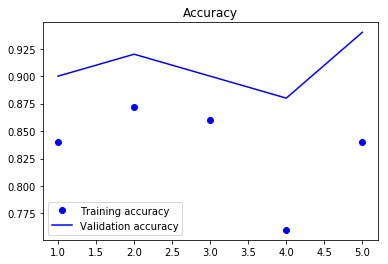

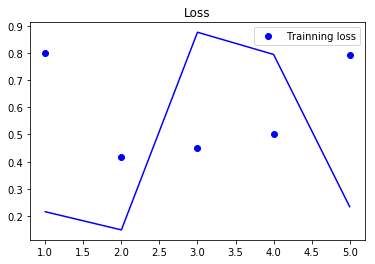

In [31]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Trainning loss")
plt.plot(epochs, val_loss, "b", Label="Validation loss")
plt.title("Loss")
plt.legend()

plt.show()

In [14]:
train_gen.class_indices

{'Faces': 0, 'bella': 1, 'cat': 2, 'cup': 3, 'dog': 4, 'lamp': 5, 'pizza': 6}

## Fine tunning
### It's not particularly usefull for this model, but I'm leving it for now

In [22]:
## Get the name of the layers you should unlock from here
conv_base.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [33]:
## Unlock the top layers of the MobileNetv2 to allow for finetuning.
print("Trainable weights before unlocking the top convlayer: ", len(model.trainable_weights))

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    #print(layer.name)
    ##block5_conv1 for the previous one
    if layer.name == 'Conv_1':
        print(layer.name)
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print("Trainable weights after unlocking the top convlayer: ", len(model.trainable_weights))

Trainable weights before unlocking the top convlayer:  9
Conv_1
Trainable weights after unlocking the top convlayer:  9


In [34]:
# compile again as to update the model with the unlocked layers 
model.compile(loss='categorical_crossentropy',
             optimizer=tf.optimizers.RMSprop(lr=2e-6),
             metrics=["acc"])

In [37]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=277//batch_size,
                              epochs=5,
#                               callbacks=callbacks,
                              validation_data=val_gen,
                              validation_steps=5,
                             )

Epoch 1/15
20/20 [==============================] - 7s 347ms/step - loss: 0.7123 - acc: 0.8400 - val_loss: 0.3936 - val_acc: 0.8800
Epoch 2/15
20/20 [==============================] - 4s 190ms/step - loss: 0.5576 - acc: 0.8660 - val_loss: 0.4025 - val_acc: 0.8800
Epoch 3/15
20/20 [==============================] - 6s 292ms/step - loss: 0.4562 - acc: 0.9000 - val_loss: 0.4061 - val_acc: 0.8800
Epoch 4/15
20/20 [==============================] - 7s 338ms/step - loss: 0.5765 - acc: 0.8600 - val_loss: 0.4116 - val_acc: 0.8800
Epoch 5/15
20/20 [==============================] - 4s 211ms/step - loss: 0.4582 - acc: 0.8660 - val_loss: 0.4100 - val_acc: 0.8800
Epoch 6/15
20/20 [==============================] - 4s 209ms/step - loss: 0.3883 - acc: 0.9000 - val_loss: 0.4124 - val_acc: 0.8800
Epoch 7/15
20/20 [==============================] - 6s 290ms/step - loss: 0.4321 - acc: 0.8969 - val_loss: 0.4292 - val_acc: 0.8800
Epoch 8/15
20/20 [==============================] - 5s 265ms/step - loss: 0.

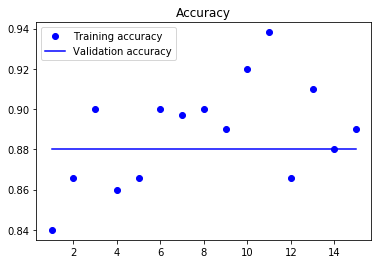

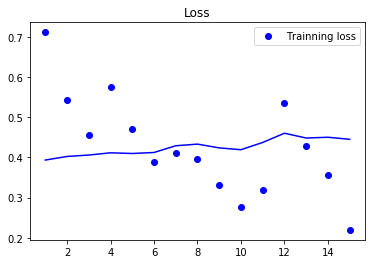

In [38]:
## Results after fine-tuning
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Trainning loss")
plt.plot(epochs, val_loss, "b", Label="Validation loss")
plt.title("Loss")
plt.legend()

plt.show()

In [39]:
test_loss, test_acc = model.evaluate_generator(test_gen, steps=10)
print('test acc:', test_acc)

test acc: 0.94


## Convert and export model to .tflite

In [60]:
quantize = 0
# this is defined at model creation, but could be handy to override here
#pruned = 1
if pruned:
    stripped_pruned_model = sparsity.strip_pruning(model)
    #stripped_pruned_model.summary()
    final_model = stripped_pruned_model
else:
    final_model = model

converter = tf.lite.TFLiteConverter.from_keras_model(final_model)

if quantize:
    #converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
    converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
    file_name = "bella_vs_theworld_mobnetv2_quantized"
elif pruned:
    file_name = "bella_vs_theworld_mobnetv2_pruned"
else:
    file_name = "bella_vs_theworld_mobnetv2"
    
    
tflite_model = converter.convert()

open("Models_tflite/" + file_name + ".tflite", "wb").write(tflite_model)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
flatten_4 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               5898752   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_14 (Dense)             (None, 7)                 903       
Total params: 8,223,303
Trainable params: 5,965,319
Non-trainable params: 2,257,984
____________________________________

32718116